In [136]:
import pathlib
import cv2
import numpy as np
import time
import itertools

from collections import Counter

from tqdm import tqdm_notebook

from matplotlib import pyplot as plt
from matplotlib import ticker

from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import os
import pandas as pd
import seaborn as sns

from scipy.ndimage.filters import gaussian_filter1d
from scipy import signal

def read_and_normalize(fp):
    scaling = 0.1
    img = cv2.imread(fp, flags=cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None,
                                 fx=scaling, fy=scaling, 
                                 interpolation=cv2.INTER_AREA)
    img = cv2.GaussianBlur(img,(7,7),0)
    img = cv2.normalize(img, None, alpha=0, beta=255, 
                                norm_type=cv2.NORM_MINMAX)
    return img

def calculate_diff_arr(file_path):
    """
    file_path: path to folder for one night's sleep images
    Subtraction between adjacent values
    """
    diff_arr = np.array([])
    img_prev = None
    for current_file in sorted(pathlib.Path(file_path).iterdir()):
        # Need to handle case when image file name ._005.jpg appears
        # Found in .../photos_processed/2019-02-27
        if current_file.name[0] == '.':
            continue

        file_string = str(current_file)
        img = read_and_normalize(file_string)

        # Have not set up averaging window yet
        if not np.any(img_prev):
            img_prev = img
            continue
            
        img_diff = np.sum(np.abs(img_prev - img))
        diff_arr = np.append(diff_arr, img_diff)
        img_prev = img
    return diff_arr

def calculate_perc_arr(file_path):
    """
    file_path: path to folder for one night's sleep images
    Percent change between adjacent values
    """
    diff_arr = np.array([])
    img_prev = None
    prev_total = None
    for current_file in sorted(pathlib.Path(file_path).iterdir()):
        # Need to handle case when image file name ._005.jpg appears
        # Found in .../photos_processed/2019-02-27
        if current_file.name[0] == '.':
            continue

        file_string = str(current_file)
        img = read_and_normalize(file_string)

        # Have not set up averaging window yet
        if not np.any(img_prev):
            img_prev = img
            prev_total = np.sum(np.abs(img))
            continue
            
        img_diff = np.sum(np.abs(img_prev - img))
        diff_arr = np.append(diff_arr, img_diff/prev_total)
        img_prev = img
        prev_total = np.sum(np.abs(img))
    return diff_arr

In [137]:
dirpath = '/Volumes/NO NAME/sleeper/photos_processed/'
save_path = '/Volumes/NO NAME/sleeper/computed_results/percentage_arrs/'
p = pathlib.Path(dirpath)
folders_list = ([x for x in p.iterdir() if x.is_dir()])

for f in tqdm_notebook(folders_list):
    diff_arr = calculate_perc_arr(f)
    np.save("{}{}.npy".format(save_path, f.stem),
            diff_arr)

In [ ]:
dirpath = '/Volumes/NO NAME/sleeper/photos_processed/'
save_path = '/Volumes/NO NAME/sleeper/computed_results/diff_arrs/'
p = pathlib.Path(dirpath)
folders_list = ([x for x in p.iterdir() if x.is_dir()])

for f in tqdm_notebook(folders_list):
    diff_arr = calculate_diff_arr(f)
    np.save("{}{}.npy".format(save_path, f.stem),
            diff_arr)

 90%|█████████ | 56/62 [08:03<00:53,  8.93s/it]




  0%|          | 0/62 [00:00<?, ?it/s]

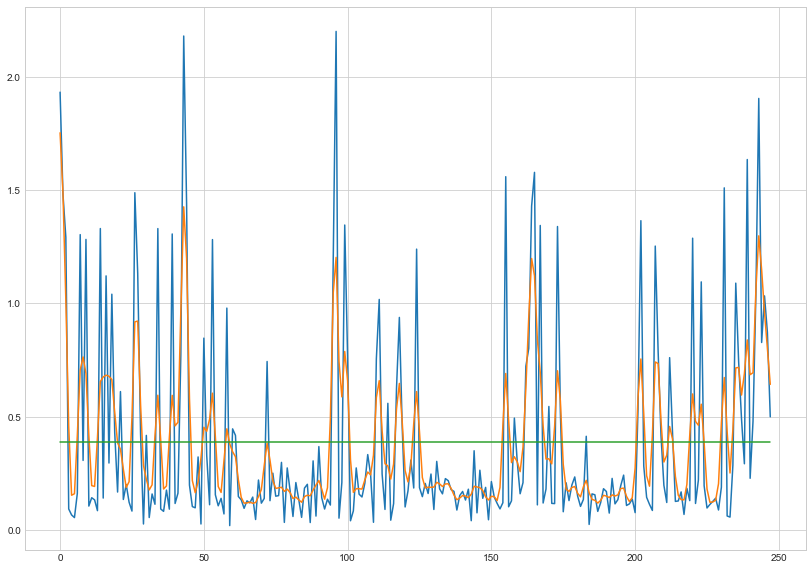

In [145]:
p = pathlib.Path('/Volumes/NO NAME/sleeper/computed_results/percentage_arrs/')
folders_list = ([x for x in sorted(p.iterdir()) if x.is_file()])

for f in tqdm(folders_list):
    diff_arr = np.load(f)
    
    mean = np.mean(diff_arr)
    mean_line = np.repeat(mean, np.size(diff_arr))
    smooth_arr = gaussian_filter1d(diff_arr, 1)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(14., 10.))
    sns.lineplot(data=diff_arr)
    sns.lineplot(data=smooth_arr)
    sns.lineplot(data=mean_line)
    plt.show()
    
    
    break

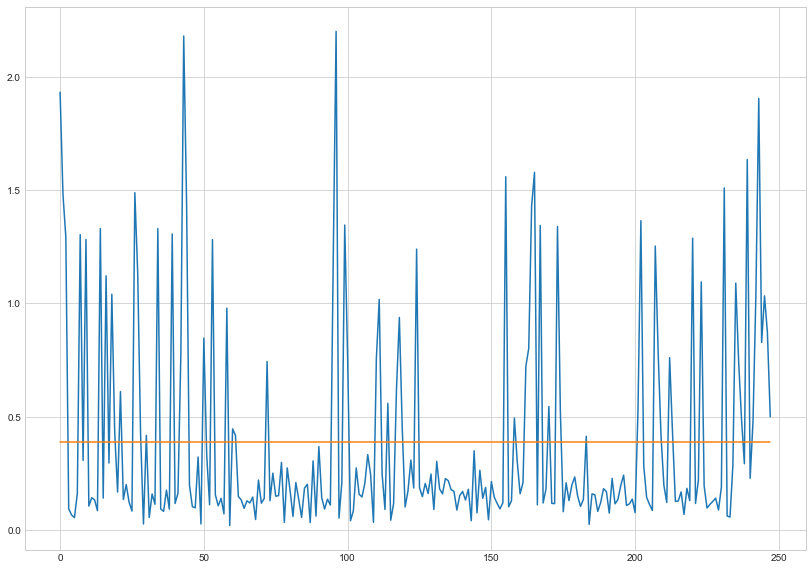

In [142]:
mean = np.mean(diff_arr)
mean_line = np.repeat(mean, np.size(diff_arr))
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14., 10.))
sns.lineplot(data=diff_arr)
sns.lineplot(data=mean_line)
plt.show()

In [11]:
signal.find_peaks(diff_arr, width=3)
peaks, _ = signal.find_peaks(log_arr, height=0)

[ 10  41  64  81  91 102 120 134 149 172 187 198 217 232]


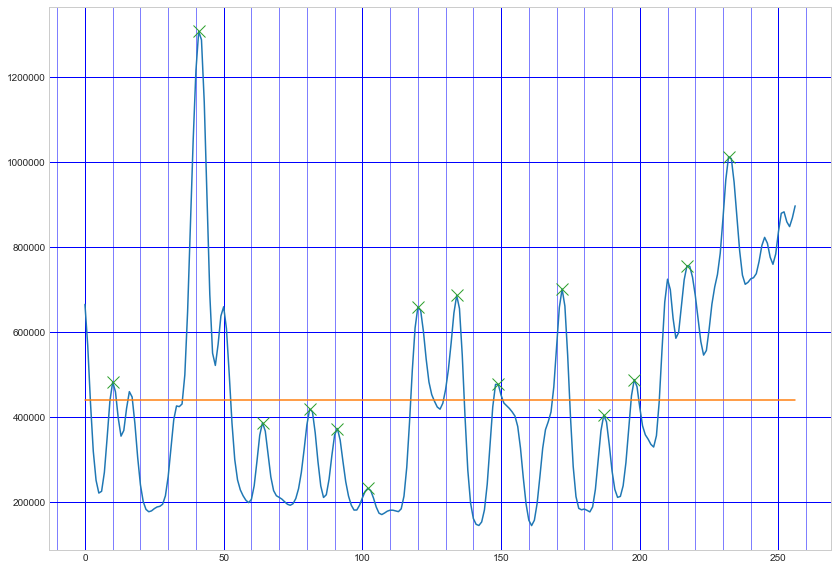

In [123]:
log_arr = gaussian_filter1d(diff_arr, 2)
mean = np.mean(log_arr)
mean_line = np.repeat(mean, np.size(diff_arr))
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14., 10.))
sns.lineplot(data=log_arr)
sns.lineplot(data=mean_line)

peaks, _ = signal.find_peaks(log_arr, width=3, prominence=50000)
print(peaks)
plt.plot(peaks, log_arr[peaks], "x", markersize=12)
plt.show()

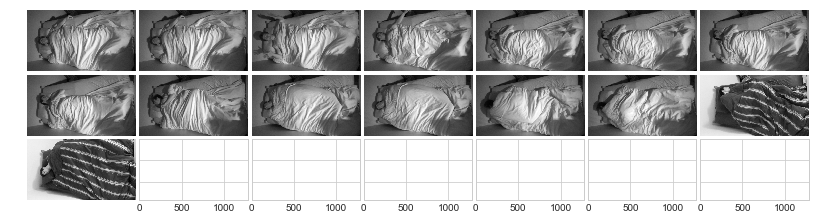

In [78]:
photos = get_files_list(folders_list[4], peaks)
display_images(photos)

In [ ]:
for f in folders_list:
    t_frames_list, std_frames_list = pr.get_sift_frames(f, verbose=0)

    folders_list = sorted(pathlib.Path(f).iterdir())
    first_file_int = get_index_of_file(f, 0)
    last_file_int = get_index_of_file(f, -1)
    duration = last_file_int - first_file_int
    
    record = record.append({'folder_name': f.stem,
                            'duration': duration,
                            'count_t_frames': len(t_frames_list),
                            't_frames_list': t_frames_list,
                            'count_std_frames': len(std_frames_list),
                            'std_frames_list': std_frames_list},
                           ignore_index=True)

display(record)
record.to_csv('/Volumes/NO NAME/sleeper/record.csv')

In [50]:
def get_index_of_file(file_path, index):
    list_of_files = sorted(pathlib.Path(file_path).iterdir())
    f = list_of_files[index]
    try:
        f = int(f.stem)
    except ValueError:
        for current_file in list_of_files:
            if current_file.name[0] != '.':
                f = current_file
                break
        f = int(f.stem)
    return f

def get_files_list(file_path, transition_frames):
    files_list = list()
    start_int = get_index_of_file(file_path, 0)
    for i in transition_frames:
        files_list.append(str(pathlib.Path(file_path)
                      .joinpath('{:03d}.jpg'
                                .format(i+start_int))))
    return files_list


def display_images(files_list):
    fig = plt.figure(1, (14., 10.))
    img_per_row = 7
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(len(files_list)//img_per_row+1, img_per_row),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )
    for i,f in enumerate(files_list):
        img = cv2.imread(f, flags=cv2.IMREAD_GRAYSCALE)
        img = cv2.normalize(img, None, alpha=0, beta=255, 
                                norm_type=cv2.NORM_MINMAX)
        img = img_as_float(img)
        grid[i].axis('off')
        grid[i].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
    return grid

In [34]:
def run(self, file_path, verbose=0):
    t_frames_list = list()
    std_frames_list = list()
    for scaling in scaling_options:
        (transition_frames, transition_values, 
         avg, std,
         transition_frames_std, transition_values_std) = self.calculate_t_frames(file_path, scaling)
        files_list = self.get_files_list(file_path, transition_frames)
        std_files_list = self.get_files_list(file_path, transition_frames_std)

        t_frames_list.append(transition_frames)
        std_frames_list.append(transition_frames_std)
        if verbose > 0:
            self.display_images(files_list)
            plt.show()
            print("Count: {}\n".format(len(transition_frames)))
            time.sleep(1)
            self.display_images(std_files_list)
            plt.show()
            print("Count: {}\n".format(len(transition_frames_std)))
    if verbose > 1:
        print("T Frames:\n{} \n\nSTD Frames:\n{}".format(t_frames_list, std_frames_list))

    return (t_frames_list, std_frames_list)

def get_counts(self, frames_list):
    counts = Counter()
    for t_frames in frames_list:
        counts += Counter(t_frames)
    c = dict(counts)
    d = [k for k,v in c.items() if v > 4]
    return (d)